# 2D U-Net Sanity Test (1)

Code from earlier project

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch
from torch import nn
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader

from segmentation_dataset_2D import SegmentationDataset2D, load_sanity_dataset

### Load Sanity Dataset Object

Loading 2D sanity dataset...
MRI shape torch.Size([3, 256, 256])
Mask shape torch.Size([1, 256, 256])


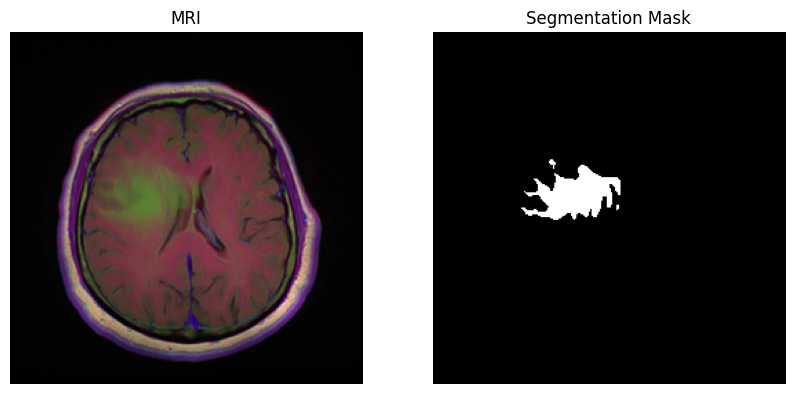

In [3]:
sanity_data = load_sanity_dataset()

X = sanity_data[0][0]
Y = sanity_data[0][1]
print('MRI shape', X.shape)
print('Mask shape',Y.shape)

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(F.to_pil_image(X))
plt.title('MRI')
plt.axis('off')

plt.subplot(122)
plt.imshow(F.to_pil_image(Y), cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.show()

### U-Net model

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // 2)
        self.up1 = Up(1024, 512 // 2)
        self.up2 = Up(512, 256 // 2)
        self.up3 = Up(256, 128 // 2)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = torch.sigmoid(x)
        return x

### Sanity Test

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

torch.Size([3, 256, 256])
torch.Size([256, 256])
tensor(0.1688, grad_fn=<MinBackward1>) tensor(0.9604, grad_fn=<MaxBackward1>)


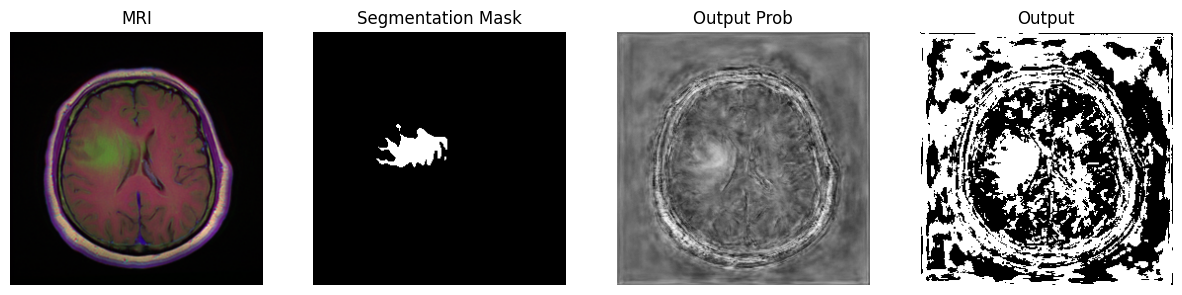

In [6]:
net = UNet().to(device)

y_prob = net(X.unsqueeze(0)).to('cpu').squeeze()

print(X.shape)
print(y_prob.shape)
print(y_prob.min(), y_prob.max())

plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(F.to_pil_image(X))
plt.title('MRI')
plt.axis('off')

plt.subplot(142)
plt.imshow(F.to_pil_image(Y), cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.subplot(143)
plt.imshow(F.to_pil_image(y_prob), cmap='gray')
plt.title('Output Prob')
plt.axis('off')

plt.subplot(144)
plt.imshow(F.to_pil_image(torch.round(y_prob)), cmap='gray')
plt.title('Output')
plt.axis('off')


plt.show()


In [7]:
def get_optimizer(net):
    return torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9)

def train(data_loader, net, optimizer, weight=(0.9, 0.1)):
    for data in data_loader:

        inputs, targets = data[0].to(device), data[1].to(device)
        outputs = net(inputs)

        loss = nn.BCELoss()(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del inputs
        del targets

        return loss.item()

Epoch: 0 Loss: 0.7159101366996765
Epoch: 1 Loss: 0.5630309581756592
Epoch: 2 Loss: 0.38478508591651917
Epoch: 3 Loss: 0.2511148452758789
Epoch: 4 Loss: 0.16474318504333496
Epoch: 5 Loss: 0.11134795099496841
Epoch: 6 Loss: 0.0833778828382492
Epoch: 7 Loss: 0.06489136815071106
Epoch: 8 Loss: 0.047346971929073334
Epoch: 9 Loss: 0.03663750737905502
Epoch: 10 Loss: 0.02935737557709217
Epoch: 11 Loss: 0.024079766124486923
Epoch: 12 Loss: 0.02098696120083332
Epoch: 13 Loss: 0.018711164593696594
Epoch: 14 Loss: 0.016640683636069298
Epoch: 15 Loss: 0.014923615381121635
Epoch: 16 Loss: 0.013680845499038696
Epoch: 17 Loss: 0.01276249811053276
Epoch: 18 Loss: 0.011846812441945076
Epoch: 19 Loss: 0.011056139133870602
Epoch: 20 Loss: 0.010305610485374928
Epoch: 21 Loss: 0.009639564901590347
Epoch: 22 Loss: 0.009050958789885044
Epoch: 23 Loss: 0.008502942509949207
Epoch: 24 Loss: 0.008243430405855179
Epoch: 25 Loss: 0.008076165802776814
Epoch: 26 Loss: 0.007691622711718082
Epoch: 27 Loss: 0.007077935

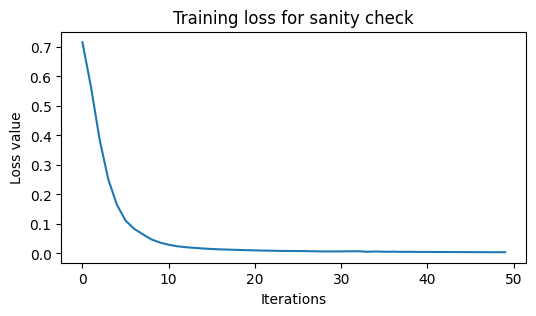

In [8]:
net.train()
optimizer = get_optimizer(net)
loss_graph = []

EPOCH = 50

sanity_loader = DataLoader(sanity_data, batch_size=1, num_workers=0, shuffle=False)
for e in range(EPOCH):
    loss = train(sanity_loader, net, optimizer)
    loss_graph.append(loss)
    print("Epoch: {} Loss: {}".format(e, loss))

plt.figure(figsize=(6, 3))
plt.plot(np.arange(0, EPOCH), loss_graph)
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.title('Training loss for sanity check')
plt.show()

torch.Size([3, 256, 256])
torch.Size([256, 256])
tensor(1.7931e-07, grad_fn=<MinBackward1>) tensor(0.9999, grad_fn=<MaxBackward1>)


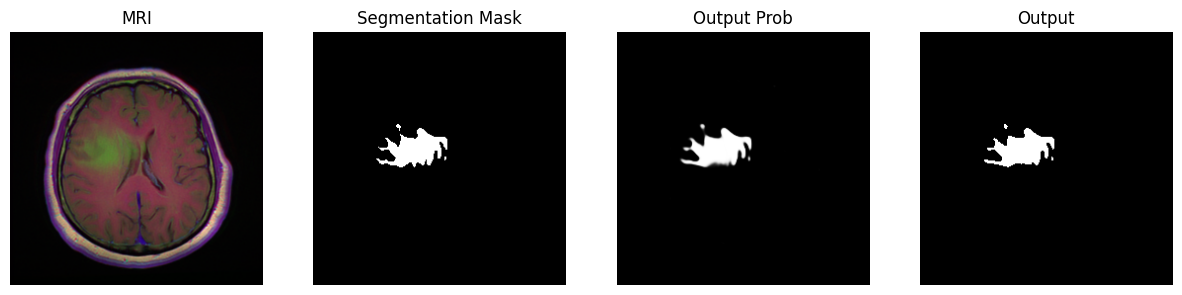

In [9]:
y_prob = net(X.unsqueeze(0)).to('cpu').squeeze()

print(X.shape)
print(y_prob.shape)
print(y_prob.min(), y_prob.max())

plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(F.to_pil_image(X))
plt.title('MRI')
plt.axis('off')

plt.subplot(142)
plt.imshow(F.to_pil_image(Y), cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.subplot(143)
plt.imshow(F.to_pil_image(y_prob), cmap='gray')
plt.title('Output Prob')
plt.axis('off')

plt.subplot(144)
plt.imshow(F.to_pil_image(torch.round(y_prob)), cmap='gray')
plt.title('Output')
plt.axis('off')

plt.show()